<img src="https://github.com/PGM-Lab/probai-2021-pyro/blob/main/Day1/Figures/blue.png?raw=1" alt="Drawing" width=2000 height=20>


# Setup
Let's begin by installing and importing the modules we'll need.

In [ ]:
%pip install -q numpy pandas seaborn matplotlib pydot graphviz
%pip install -q --no-deps pyro-ppl torch

import numpy as np
import pandas as pd
import seaborn as sns
import torch
import types
import matplotlib.pyplot as plt
from pyro.infer import Predictive
import pyro
from pyro.distributions import Normal, Uniform, Delta, Gamma, Binomial
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import torch.distributions.constraints as constraints
import pyro.optim as optim
from pyro.contrib.autoguide import AutoNormal,AutoMultivariateNormal
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# for CI testing
pyro.set_rng_seed(1)
pyro.enable_validation(True)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 8.3 MB/s eta 0:00:00


<img src="https://github.com/PGM-Lab/probai-2021-pyro/blob/main/Day1/Figures/blue.png?raw=1" alt="Drawing" width=2000 height=20>

# 1. Dataset and miscellaneous

The following example is taken from \[1\].  We would like to explore the relationship between topographic heterogeneity of a nation as measured by the Terrain Ruggedness Index (variable *rugged* in the dataset) and its GDP per capita. In particular, it was noted by the authors in \[1\] that terrain ruggedness or bad geography is related to poorer economic performance outside of Africa, but rugged terrains have had a reverse effect on income for African nations. Let us look at the data \[2\] and investigate this relationship.  We will be focusing on three features from the dataset:
  - `rugged`: quantifies the Terrain Ruggedness Index
  - `cont_africa`: whether the given nation is in Africa
  - `rgdppc_2000`: Real GDP per capita for the year 2000

  
We will take the logarithm for the response variable GDP as it tends to vary exponentially.

In [ ]:
np.random.seed(42)
DATA_URL = "https://github.com/pyro-ppl/brmp/raw/refs/heads/master/brmp/examples/rugged_data.csv"
data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")
df = data[["cont_africa", "rugged", "rgdppc_2000"]]
df = df.sample(frac=1)
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])
df = df[["cont_africa", "rugged", "rgdppc_2000"]]

# Divide the data into predictors and response and store the data in numpy arrays organized in a dictionary with one
# element for african and non-african nations, respectively.
data = torch.tensor(df.values, dtype=torch.float)
x_data = {'non-african': data[data[:, 0] == 0, 1].reshape(-1,1), 'african': data[data[:, 0] == 1, 1].reshape(-1,1)}
y_data = {'non-african': data[data[:, 0] == 0, -1], 'african': data[data[:, 0] == 1, -1]}

print(f"Number of african countries: {x_data['african'].shape[0]}")
print(f"Number of non-african countries: {x_data['non-african'].shape[0]}")

Number of african countries: 49
Number of non-african countries: 121


In [ ]:
# Display first 10 entries
display(df[0:10])

,cont_africa,rugged,rgdppc_2000
69,0,1.098,10.154169
206,0,0.284,8.207281
9,0,2.688,7.792343
109,0,0.540,7.527828
196,0,0.715,10.161994
93,0,0.346,9.489761
15,1,1.780,6.432380
55,0,0.003,8.688069
227,0,1.729,8.062162
201,1,0.419,6.710706


In [ ]:
def prepare_figure(title='Scatter plot of data', x_data_: dict = None, y_data_: dict = None):
    """
    Plot the data and return the figure axis for possible subsequent additional plotting.
    :param title: Title of the plot
    :param x_data_: dictionary with data for the prdictor variable
    :param y_data_: dictionary with data for the response variable.
    :return: Figure axis.
    """
    if x_data_ is None and y_data_ is None:
        x_data_ = x_data
        y_data_ = y_data

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
    fig.suptitle(title, fontsize=16)

    for idx, cont in enumerate(x_data):
        ax[idx].scatter(x_data_[cont], y_data_[cont], c='black')
        ax[idx].set(xlabel="Terrain Ruggedness Index", ylabel="log GDP (2000)",
                    title=f"{cont} nations")

    return ax

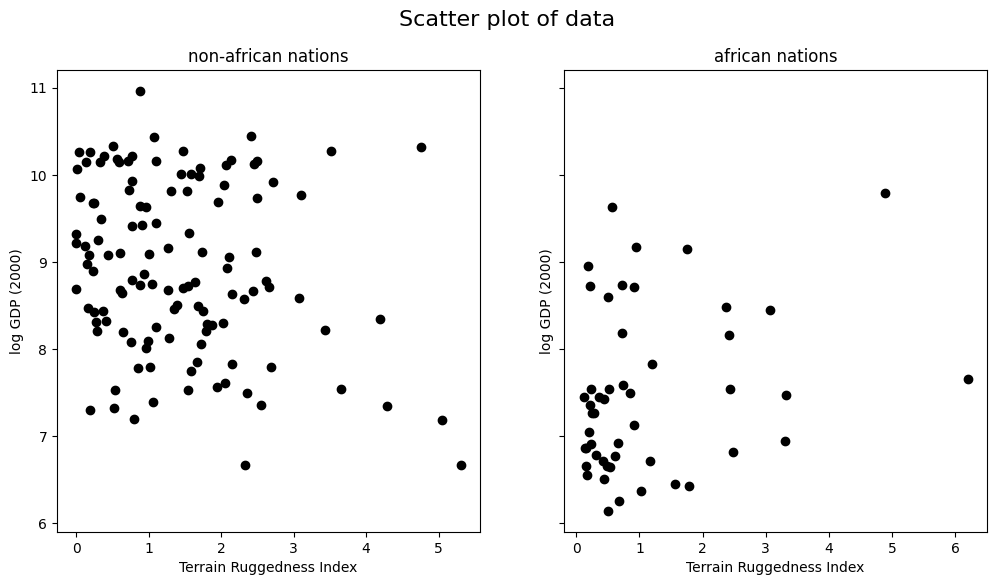

In [ ]:
# Let's display the data
prepare_figure('Scatter plot of data')
plt.show()

## Helper functions

In [ ]:
def get_data_subsets(x_data_: dict, y_data_: dict, frac: float = 1, verbose=True):
    """
    Sample a subset of the data sets. Both data sets are again dictionaries with elements for
    african and non-african nations.
    :param x_data_: Dictionary with data for the predictor variable
    :param y_data_: Dictionary with data for the response variable
    :param frac: fraction of the data to be sampled
    :param verbose: How much detail should be displayed
    :return: Four dictionaries, two for each of the subsets.
    """

    x_data_ic = {}
    y_data_ic = {}
    x_data_ec = {}
    y_data_ec = {}

    # Iterate over the two keys (african and non-african) and pick out the data
    for cont in x_data_.keys():
        indices = np.random.choice(x_data_[cont].shape[0], int(x_data_[cont].shape[0] * frac), replace=False)
        mask = np.zeros(x_data_[cont].shape[0], dtype=bool)
        mask[indices] = True
        x_data_ic[cont] = x_data_[cont][mask, :]
        y_data_ic[cont] = y_data_[cont][mask]
        x_data_ec[cont] = x_data_[cont][~mask, :]
        y_data_ec[cont] = y_data_[cont][~mask]

    if verbose:
        for cont in x_data_ic.keys():
            print(f"{cont} entries: {x_data_ic[cont].shape[0]}")

    return x_data_ic, y_data_ic, x_data_ec, y_data_ec

In [ ]:
def plot_model(ax, x_data_: dict = None, model: dict = None, linewith: int = 2,
               label: str = None, line_color: str = 'red', num_samples: int = 0):
    """
    Plot the model using the figure axes in ax
    :param ax: Figure axes
    :param x_data_: dictionary with data for the predictor variable
    :param model: The model (i.e., weights/parameters and possibly covariance) in a dictionary with one element for
    african and non-african.
    :param linewith: width of line to be plotted
    :param label: the label to go with the model plot
    :param line_color: color of line to be plotted
    :param num_samples: If the model also contains a covariance matrix we treat the weights 'w' as mean values and
    sample realizations of the model from the weight distribution.
    :return: Figure axes.
    """
    if x_data_ is None:
        x_data_ = x_data

    if model is None:
        print("Ups, no model supplied")
    for idx, cont in enumerate(model):
        # We treat the first element in the weight matrix as the bias hence we add a constant one column to the data
        x_aug = np.c_[np.ones(x_data_[cont].shape[0]), x_data_[cont]]

        # Sample from the distribution over the weights if a covariance matrix is given.
        if num_samples > 0 and 'cov' in model[cont]:
            for _ in range(num_samples):
                w_sample = np.random.multivariate_normal(mean=model[cont]['w'],
                                                         cov=model[cont]['cov'])
                ax[idx].plot(x_data[cont], x_aug @ w_sample , 'g-', alpha=.05)

        ax[idx].plot(x_data_[cont], x_aug @ model[cont]['w'],
                     color=line_color,
                     linewidth=linewith,
                     label=label)
        if label is not None:
            ax[idx].legend()
    return ax

In [ ]:
x_train, y_train, x_test, y_test = get_data_subsets(x_data, y_data, 0.7, verbose=False)


<img src="https://github.com/PGM-Lab/probai-2021-pyro/blob/main/Day1/Figures/blue.png?raw=1" alt="Drawing" width=2000 height=20>


# 1. Linear regression

Linear regression is one of the most commonly used supervised learning tasks in machine learning. Suppose we are given a dataset $\mathcal{D}$ of the form

$$ \mathcal{D}  = \{ (X_i, y_i) \} \qquad \text{for}\qquad i=1,2,...,N$$

The goal of linear regression is to fit a function to the data of the form:

$$ y = w X + b + \epsilon, $$

where $w$ and $b$ are learnable parameters and $\epsilon$ represents observation noise. Specifically $w$ is a matrix of weights and $b$ is a bias vector.

Let's first implement linear regression in PyTorch and learn point estimates for the parameters $w$ and $b$.  Then we'll see how to incorporate uncertainty into our estimates.

## Model
We would like to predict log GDP per capita of a nation as a function of whether the nation is in Africa and its Terrain Ruggedness Index. As indicated by the data partitioning above, we will make one linear regression model for african and non-african nations, respectively.

To sprcify our regression model, we will define a specific object encapsulating the model.  Our input `x_data` is a tensor of size $N \times 1$ and our output `y_data` is a tensor of size $N \times 1$.  The method `predict(self,x_data)` defines a linear transformation of the form $Xw + b$ where $w$ is the weight matrix and $b$ is the additive bias.

The parameters of the model are defined using ``torch.nn.Parameter``, and will be learned during training.

In [ ]:
class RegressionModel():
    def __init__(self):
        self.w = torch.nn.Parameter(torch.zeros(1, 1))
        self.b = torch.nn.Parameter(torch.zeros(1, 1))

    def params(self):
        return {"b": self.b, "w": self.w}

    def predict(self, x_data):
        return (self.b + torch.mm(self.w, torch.t(x_data))).squeeze(0)

## Training
We will use the mean squared error (MSE) as our loss and Adam as our optimizer. We would like to optimize the parameters of the `regression_model` neural net above. We will use a somewhat large learning rate of `0.05` and run for 1000 iterations.

In [ ]:
def least_squares_solution(x_data, y_data, verbose=True):
    regression_model = RegressionModel()
    loss_fn = torch.nn.MSELoss(reduction='sum')
    optim = torch.optim.Adam(regression_model.params().values(), lr=0.05)
    num_iterations = 1000

    param = {}
    for cont in x_data.keys():
        param[cont] = {}
        if verbose:
            print(f"Learning model for {cont} nations")
        for j in range(num_iterations):
            # run the model forward on the data
            y_pred = regression_model.predict(torch.tensor(x_data[cont], dtype=torch.float))
            # calculate the mse loss
            loss = loss_fn(y_pred, torch.tensor(y_data[cont], dtype=torch.float))
            # initialize gradients to zero
            optim.zero_grad()
            # backpropagate
            loss.backward()
            # take a gradient step
            optim.step()
            if (j + 1) % 500 == 0 and verbose:
                print("[iteration %04d] loss: %.4f" % (j + 1, loss.item()))

        # Store the learned parameters
        param[cont]['w'] = np.r_[regression_model.params()['b'].detach().numpy().copy().flatten(),
                      np.transpose(regression_model.params()['w'].detach().numpy()).copy().flatten()]
    # Inspect learned parameters
    if verbose:
        print("Learned parameters:")
        for cont in param.keys():
            print(f"{cont}: weights = {param[cont]['w']}")

    return param

In [ ]:
# Learn the model
model_lr = least_squares_solution(x_train, y_train)

Learning model for non-african nations


/tmp/ipython-input-2942920294.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = regression_model.predict(torch.tensor(x_data[cont], dtype=torch.float))
/tmp/ipython-input-2942920294.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = loss_fn(y_pred, torch.tensor(y_data[cont], dtype=torch.float))


[iteration 0500] loss: 79.9509
[iteration 1000] loss: 70.2930
Learning model for african nations
[iteration 0500] loss: 25.0792
[iteration 1000] loss: 25.0628
Learned parameters:
non-african: weights = [ 9.364129   -0.28358942]
african: weights = [7.162794  0.2699494]


## Evaluating the model

We now plot the regression line learned for african and non-african nations relating the rugeedness index with the GDP of the country.

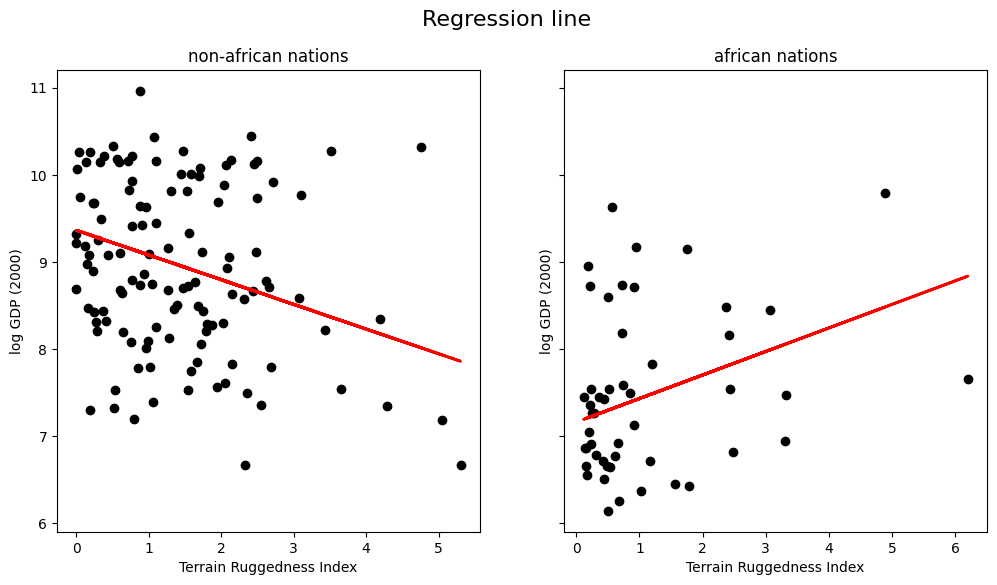

In [ ]:
ax = prepare_figure(title='Regression line')
plot_model(ax, model=model_lr, x_data_=x_data)
plt.show()

## The relationship between ruggedness and log GPD

Using this analysis, we can estimate the relationship between ruggedness and log GPD. As can be seen, this relationship is positive for African nations, but negative for Non African Nations.

In [ ]:
print(f"Slope for non-african nations: {model_lr['non-african']['w'][1]}")
print(f"Slope for african nations: {model_lr['african']['w'][1]}")

Slope for non-african nations: -0.2835894227027893
Slope for african nations: 0.26994940638542175


<img src="https://github.com/PGM-Lab/probai-2021-pyro/blob/main/Day1/Figures/blue.png?raw=1" alt="Drawing" width=2000 height=20>


# Bayesian Linear Regression


[Bayesian modeling](http://mlg.eng.cam.ac.uk/zoubin/papers/NatureReprint15.pdf) offers a systematic framework for reasoning about model uncertainty. Instead of just learning point estimates, we're going to learn a _distribution_ over parameters that are consistent with the observed data.

In order to make our linear regression Bayesian, we need to put priors on the model parameters $w$, $b$ and $\theta$. These are distributions that represent our prior belief about reasonable values for these parameters (before observing any data).

A graphical representation would be as follows:

<img src="https://github.com/PGM-Lab/probai-2021-pyro/raw/main/Day3/Figures/BayesianLinearRegressionPGM.png" width=800>

## Model

We now have all the ingredients needed to specify our model. Note the priors that we are using for the different latent variables in the model. The prior on the intercept parameter is very flat as we would like this to be learnt from the data. We are using a weakly regularizing prior on the regression coefficients to avoid overfitting to the data.

We use the `obs` argument to the `pyro.sample` statement to condition on the observed data `y_data` with a learned observation noise parameter.

In [ ]:
def model(x_data_, y_data_):
    # weight/slope prior
    s = pyro.sample("s", Normal(0, 1000.))

    # bias/intercept prior
    b = pyro.sample("b", Normal(0., 1000.))

    # Compute the predicion mean
    mean = (b + x_data_ * s).squeeze(-1)
    pyro.deterministic("predictive_mean", mean)


    with pyro.plate("plate_x", len(x_data_)):
        # Introduce a Normal distribution and condition on the observed data
        pyro.sample("y", Normal(loc=mean, scale=1.0), obs=y_data_)

    return mean

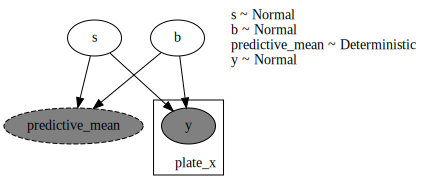

In [ ]:
pyro.render_model(model, model_args=(x_data['african'], y_data['african']), render_distributions=True)

## Guide

In order to do inference we're going to need a guide, i.e. a variational family of distributions.  

### Autoguides
We will use Pyro's [autoguide library](http://docs.pyro.ai/en/dev/contrib.autoguide.html) to automatically place Gaussians with diagonal covariance on all of the distributions in the model.  Under the hood, this defines a `guide` function with `Normal` distributions with learnable parameters corresponding to each `sample()` in the model.  Autoguide also supports learning MAP estimates with `AutoDelta` or composing guides with `AutoGuideList` (see the [docs](http://docs.pyro.ai/en/dev/contrib.autoguide.html) for more information).

## Inference

To do inference we'll use stochastic variational inference (SVI) (for an introduction to SVI, see [SVI Part I](svi_part_i.ipynb)). Just like in the non-Bayesian linear regression, each iteration of our training loop will take a gradient step, with the difference that in this case, we'll use the ELBO objective instead of the MSE loss by constructing a `Trace_ELBO` object that we pass to `SVI`.

Here `Adam` is a thin wrapper around `torch.optim.Adam` (see [here](svi_part_i.ipynb#Optimizers) for a discussion). To take an ELBO gradient step we simply call the step method of SVI. Notice that the data argument we pass to step will be passed to both model() and guide().  The complete training loop is as follows:

In [ ]:
def train(x_data, y_data, model, num_iterations=2000, verbose=True):
    optim = Adam({"lr": 0.1})
    param = {}
    for cont in x_data.keys():
        guide = AutoNormal(model)
        svi = SVI(model, guide, optim, loss=Trace_ELBO(), num_samples=10)
        pyro.clear_param_store()

        for j in range(num_iterations):
            # calculate the loss and take a gradient step
            loss = svi.step(x_data[cont], y_data[cont])
            if j % 500 == 0:
                print("[iteration %04d] loss: %.4f" % (j, loss / len(data)))
        param[cont] = {'vi_parameters': pyro.get_param_store().get_state(),
                       'guide': guide}

    return param

In [ ]:
# Insert you own guide if you like
param = train(x_train, y_train, model)

[iteration 0000] loss: 20.2271
[iteration 0500] loss: 0.7785
[iteration 1000] loss: 0.7710
[iteration 1500] loss: 0.7620
[iteration 0000] loss: 6.1349
[iteration 0500] loss: 0.3611
[iteration 1000] loss: 0.3616
[iteration 1500] loss: 0.3596


In [ ]:
# Print the parameters
for cont in param.keys():
    header = f"\nThe parameters for {cont} nations:"
    print(header)
    print(f"-"*len(header))
    for name, value in param[cont]['vi_parameters']['params'].items():
        print(f"{name:<25}: {value.detach().numpy()}")


The parameters for non-african nations:
----------------------------------------
AutoNormal.locs.s        : -0.25650978088378906
AutoNormal.scales.s      : -2.7314882278442383
AutoNormal.locs.b        : 9.36478042602539
AutoNormal.scales.b      : -2.19657826423645

The parameters for african nations:
------------------------------------
AutoNormal.locs.s        : 0.17352798581123352
AutoNormal.scales.s      : -1.9987983703613281
AutoNormal.locs.b        : 7.094790458679199
AutoNormal.scales.b      : -2.158911943435669


<img src="https://github.com/PGM-Lab/probai-2021-pyro/blob/main/Day1/Figures/blue.png?raw=1" alt="Drawing" width=2000 height=20>

# Model evaluation

The plot below visualizes the uncertainty in the Bayesian linear regression model learned using variational inference. Each faint green line represents a regression line sampled from the variational posterior distribution over the model parameters (slope and intercept). The red line shows the mean of these sampled regression lines, representing the average predicted relationship between terrain ruggedness and log GDP according to the model's posterior. The spread of the green lines indicates the model's confidence in its predictions; a wider spread suggests higher uncertainty in the estimated relationship.

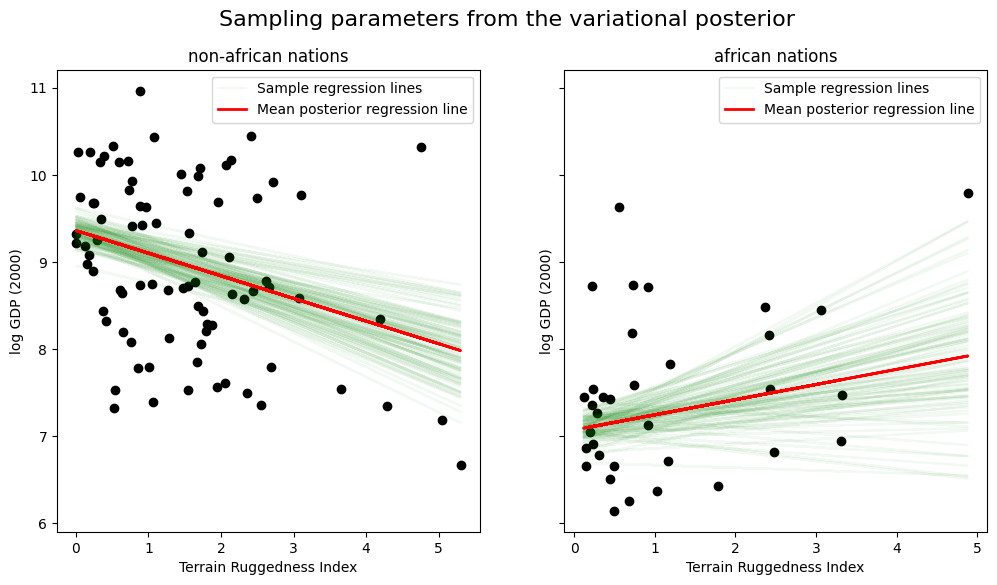

In [ ]:
ax = prepare_figure("Sampling parameters from the variational posterior", x_data_=x_train, y_data_=y_train)
num_samples = 100
for cont in x_data.keys():
    # Prepare data for plotting
    pyro.get_param_store().set_state(param[cont]['vi_parameters'])
    predictive = pyro.infer.Predictive(model, guide=param[cont]['guide'], num_samples=num_samples)
    svi_samples_posterior = predictive(x_train[cont], None)
    x_train_cont = x_train[cont]
    y_samples_cont = svi_samples_posterior['predictive_mean'].detach().numpy()

    # Get the correct plot index
    plot_idx = list(x_data.keys()).index(cont)

    # Convert x_train_cont to numpy for consistent plotting
    x_train_cont_np = x_train_cont.detach().numpy().squeeze()

    # Plot sampled regression lines
    for i in range(num_samples):  # Plot 100 sample lines
        label = 'Sample regression lines' if i == 0 else ""
        ax[plot_idx].plot(x_train_cont_np, y_samples_cont[i, :].squeeze(), 'g-', alpha=.05, label=label)

    # Plot the mean posterior regression line
    mean_y_pred = np.mean(y_samples_cont, axis=0)
    ax[plot_idx].plot(x_train_cont_np, mean_y_pred.squeeze(), 'r-', linewidth=2, label='Mean posterior regression line')
    ax[plot_idx].legend()

plt.show()

### Get the posterior predictive
Given the posterior distribution
$$
p({\bf w}| {\bf X}, {\bf y}) =  {\mathcal N}({\bf w}| {\bf w}_p, \Sigma_p),
$$

where ${\bf w}_p$ and $\Sigma_p$ is the (approximate) posterior mean and (approximate) posterior covariance, respectively, we can calculate the posterior predictive distribution for a data point ${\bf x}$:
$$
p(y | {\bf x}, {\mathcal D}) = \int \mathcal N(y|{\bf x}^T{\bf w}) {\mathcal N}({\bf w}| {\bf w}_p, \Sigma_p),
$$


See, e.g., Murphy (2022), *Probabilistic machine learning: an introduction*.

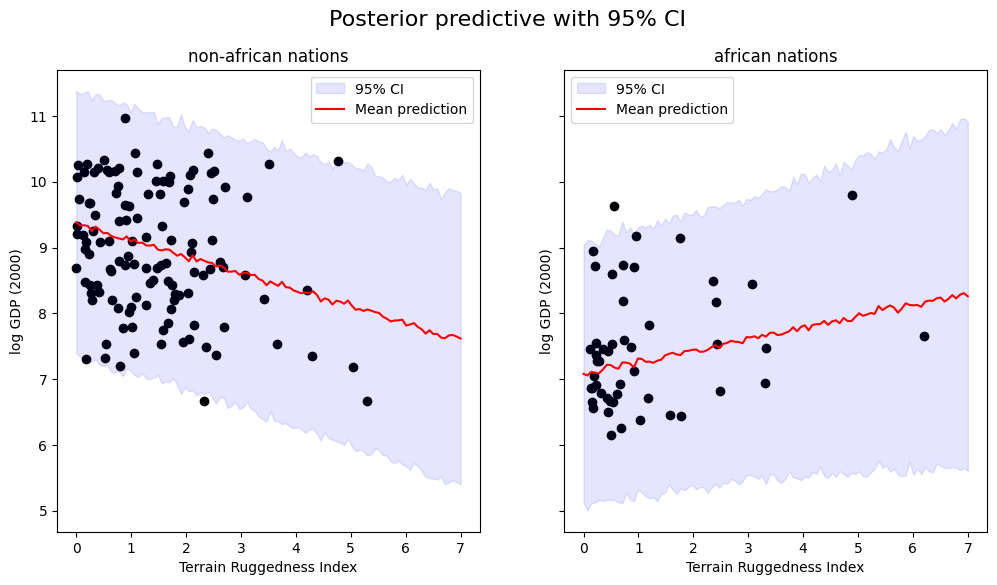

In [ ]:
x_test_points = np.linspace(0, 7, 100)
svi_samples = {}
for cont in x_data.keys():
    pyro.get_param_store().set_state(param[cont]['vi_parameters'])
    predictive = pyro.infer.Predictive(model, guide=param[cont]['guide'], num_samples=1000)
    svi_samples[cont] = predictive(torch.tensor(x_test_points), None)
ax = prepare_figure('Posterior predictive with 95% CI', x_data_=x_data, y_data_=y_data)
for idx, cont in enumerate(x_data.keys()):
    y_predictive_mean = torch.squeeze(svi_samples[cont]['y']).detach().numpy()
    y_predictive_std = np.std(y_predictive_mean, axis=0)
    ax[idx].fill_between(x_test_points,
                         np.mean(y_predictive_mean, axis=0) - 2 * y_predictive_std,
                         np.mean(y_predictive_mean, axis=0) + 2 * y_predictive_std,
                         color='b',
                         alpha=0.1, label='95% CI')
    ax[idx].plot(x_test_points, np.mean(y_predictive_mean, axis=0), color='r', label='Mean prediction')
    ax[idx].legend()
    ax[idx].set_xlabel("Terrain Ruggedness Index")
    ax[idx].set_ylabel("log GDP (2000)")


plt.show()

## Bayesian Model Averaging and Log-Likelihood Validation

The comparison we've implemented demonstrates the value of Bayesian Model Averaging:

**Individual Models from Variational Posterior**: Here we sample multiple parameter sets from our learned variational posterior distribution. Each sample represents a different plausible model that could explain our training data. By computing the log-likelihood of each individual sample on test data, we get a distribution of performance scores. This shows us the range of possible outcomes we might expect from different parameter realizations, giving us insight into parameter uncertainty.

**Bayesian Model Averaging (BMA)**: This is the most principled Bayesian approach. Instead of picking one model or looking at individual samples, we integrate over the entire posterior distribution to make predictions. The log-likelihood here represents how well the "average" model (weighted by posterior probability) explains the test data. This approach naturally accounts for all sources of uncertainty and typically provides the most robust predictions.

The key insight is that **BMA generally outperforms both individual models** because it doesn't commit to a single parameter setting. Instead, it leverages the full posterior distribution to make predictions that are robust to parameter uncertainty. If you see that BMA has higher log-likelihood than the mean of individual models, this suggests that the averaging process is successfully combining multiple plausible models to improve overall performance. This is a fundamental advantage of Bayesian approaches: they don't just give you predictions, they give you predictions with built-in uncertainty quantification that often leads to better generalization.

In [ ]:
def compute_log_likelihoods_comparison(x_test, y_test, param, model, num_samples=100):
    """
    Compute log-likelihoods for both individual models and Bayesian model averaging
    using the same posterior samples for fair comparison.

    Args:
        x_test: Test data features
        y_test: Test data targets
        param: Trained variational parameters
        model: Pyro model function
        num_samples: Number of samples to draw from posterior

    Returns:
        Dictionary with both individual and BMA log-likelihoods for each continent
    """
    results = {}

    for cont in x_test.keys():
        # Set the variational parameters for this continent
        pyro.get_param_store().set_state(param[cont]['vi_parameters'])

        # Create predictive object to sample from posterior
        predictive = pyro.infer.Predictive(model, guide=param[cont]['guide'], num_samples=num_samples)

        # Sample parameters from variational posterior
        posterior_samples = predictive(x_test[cont], None)

        # Extract slope, bias, and precision samples
        slopes = posterior_samples['s'].squeeze().detach().numpy()  # Shape: (num_samples,)
        biases = posterior_samples['b'].squeeze().detach().numpy()  # Shape: (num_samples,)
        #precisions = posterior_samples['theta'].squeeze().detach().numpy()  # Shape: (num_samples,)

        # Extract predictive samples for BMA
        y_predictive_samples = torch.mean(posterior_samples['y'], dim=0).detach().numpy()  # Shape: (num_test_points,)

        # Get test data
        x_test_cont = x_test[cont].squeeze()
        y_test_cont = y_test[cont].squeeze()

        # Convert to numpy for computation
        x_test_cont_np = x_test_cont.detach().numpy() if torch.is_tensor(x_test_cont) else x_test_cont
        y_test_cont_np = y_test_cont.detach().numpy() if torch.is_tensor(y_test_cont) else y_test_cont

        # Compute log-likelihood for individual models
        individual_log_likelihoods = []
        bma_log_likelihood = []
        for i in range(num_samples):
            # Get parameters for this sample
            s = slopes[i]
            b = biases[i]
            theta = 1.0 #precisions[i]

            # Linear prediction: y_pred = b + s * x
            y_pred = b + s * x_test_cont_np

            # Compute log-likelihood assuming Normal distribution with learned precision
            # log p(y|theta) = -0.5 * N * log(2π) - 0.5 * N * log(1/theta) - 0.5 * theta * sum((y - y_pred)^2)
            N = len(y_test_cont_np)
            log_likelihood_test = -0.5 * np.log(2 * np.pi) - 0.5 * np.log(1/theta) - 0.5 * theta * (y_test_cont_np - y_pred)**2

            individual_log_likelihoods.append(log_likelihood_test)

        # Shape: (num_samples, num_test_points)
        # - num_samples: number of posterior samples (1000)
        # - num_test_points: number of test data points for this continent
        individual_log_likelihoods = np.stack(individual_log_likelihoods)

        bma_log_likelihood = np.mean(np.logaddexp.reduce(individual_log_likelihoods,axis=0) - np.log(individual_log_likelihoods.shape[0]))

        individual_log_likelihoods = np.mean(individual_log_likelihoods,axis=1)


        # Compute log-likelihood for MAP model
        # Store results
        results[cont] = {
            'individual_models': individual_log_likelihoods,
            'bma': bma_log_likelihood,
        }

    return results

Computing log-likelihoods over test data...


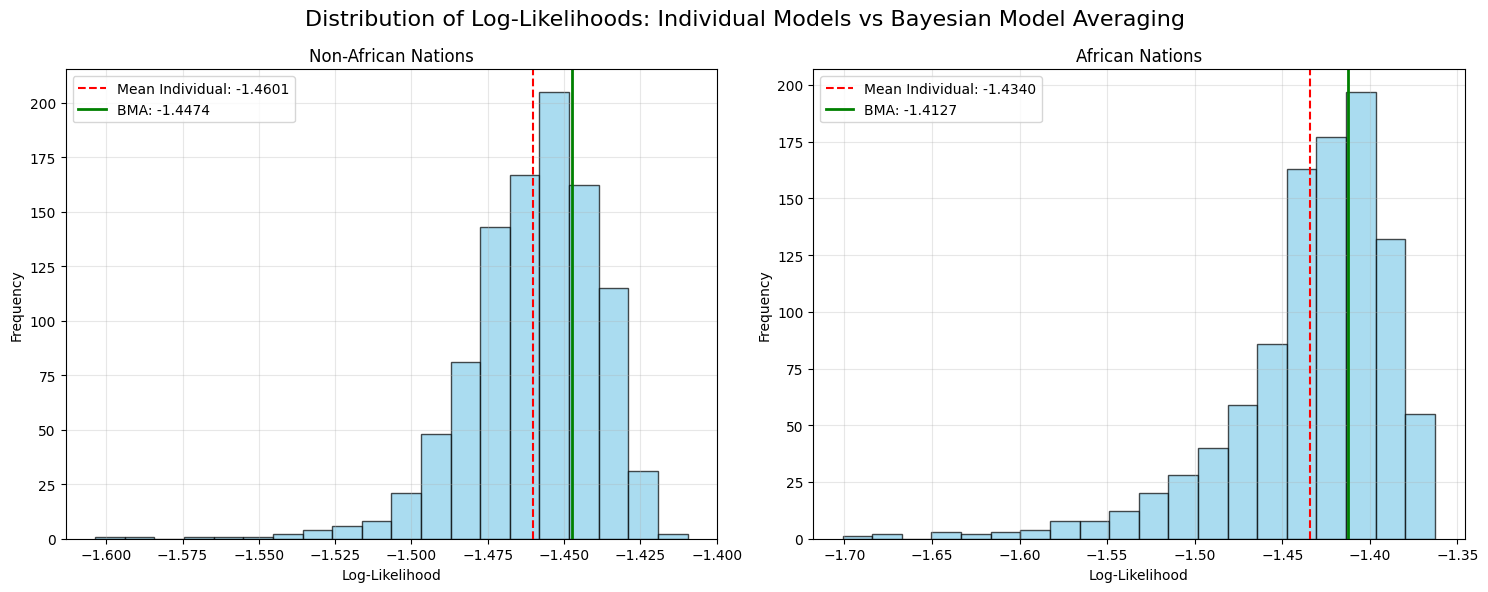

In [ ]:


# Compute log-likelihoods
print("Computing log-likelihoods over test data...")

results = compute_log_likelihoods_comparison(x_test, y_test, param, model, num_samples=1000)


# Visualize the distribution of individual model log-likelihoods
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Distribution of Log-Likelihoods: Individual Models vs Bayesian Model Averaging', fontsize=16)

for idx, cont in enumerate(x_test.keys()):
    individual_ll_cont = results[cont]['individual_models']
    bma_ll_cont = results[cont]['bma']

    # Plot histogram of individual model log-likelihoods
    axes[idx].hist(individual_ll_cont, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    axes[idx].axvline(np.mean(individual_ll_cont), color='red', linestyle='--',
                      label=f'Mean Individual: {np.mean(individual_ll_cont):.4f}')
    axes[idx].axvline(bma_ll_cont, color='green', linestyle='-', linewidth=2,
                      label=f'BMA: {bma_ll_cont:.4f}')

    axes[idx].set_xlabel('Log-Likelihood')
    axes[idx].set_ylabel('Frequency')
    axes[idx].set_title(f'{cont.title()} Nations')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Analyzing the Bayesian Posterior

Now that we have trained our Bayesian linear regression models for both African and non-African countries, we can examine the posterior distributions of the learned parameters to gain insights into the relationship between terrain ruggedness and economic development. By analyzing the posterior distributions of the slopes and intercepts, we can quantify the uncertainty in our parameter estimates and make probabilistic statements about how terrain ruggedness affects GDP differently across these two groups of countries. This Bayesian approach allows us to go beyond point estimates and understand the full range of plausible parameter values given our data and prior beliefs.

### Relationship between GDP and ruggedness by plotting the distribution of the slope for ruggedness for african and nn-african nations.

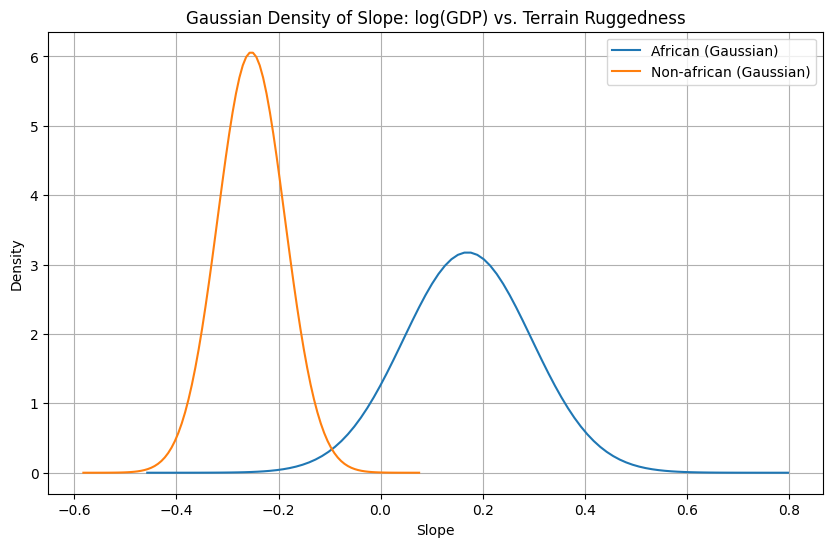

In [ ]:
from scipy.stats import norm

# Calculate mean and standard deviation for African and Non-African slopes
mean_african_slope = np.mean(svi_samples['african']['s'].squeeze().detach().numpy())
std_african_slope = np.std(svi_samples['african']['s'].squeeze().detach().numpy())

mean_non_african_slope = np.mean(svi_samples['non-african']['s'].squeeze().detach().numpy())
std_non_african_slope = np.std(svi_samples['non-african']['s'].squeeze().detach().numpy())

# Generate x-values for plotting the density
x_values_african = np.linspace(mean_african_slope - 5 * std_african_slope, mean_african_slope + 5 * std_african_slope, 100)
x_values_non_african = np.linspace(mean_non_african_slope - 5 * std_non_african_slope, mean_non_african_slope + 5 * std_non_african_slope, 100)

# Calculate the Gaussian probability density for the generated x-values
pdf_african = norm.pdf(x_values_african, mean_african_slope, std_african_slope)
pdf_non_african = norm.pdf(x_values_non_african, mean_non_african_slope, std_non_african_slope)

# Plot the densities
plt.figure(figsize=(10, 6))
plt.plot(x_values_african, pdf_african, label='African (Gaussian)')
plt.plot(x_values_non_african, pdf_non_african, label='Non-african (Gaussian)')
plt.title("Gaussian Density of Slope: log(GDP) vs. Terrain Ruggedness")
plt.xlabel("Slope")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

<img src="https://github.com/PGM-Lab/probai-2021-pyro/blob/main/Day1/Figures/blue.png?raw=1" alt="Drawing" width=2000 height=20>

# Exercise 1: Prior Sensitivity Analysis
**Objective**: Understand how different prior choices affect the posterior distributions.

**Task**:
1. Modify the priors in the `model` function to use different distributions:
   - Try `Normal(0, 1)` instead of `Normal(0, 1000)` for the slope prior
   
2. Retrain the model and compare the posterior distributions
3. Plot the new posterior distributions alongside the original ones
4. Discuss how the choice of priors affects the results

<img src="https://github.com/PGM-Lab/probai-2021-pyro/blob/main/Day1/Figures/blue.png?raw=1" alt="Drawing" width=2000 height=20>


# Exercise 2: Random Precision with Gamma Prior
**Objective**: Treat the precision of the random variable Y as a random variable with a Gamma prior.

**Task**:
1. Modify the model definition to treat the precision parameter `theta` as a random variable with a Gamma prior
2. Train the model using SVI and compare results with the original fixed-precision model
3. Analyze how the uncertainty in precision affects the posterior distributions of other parameters
4. Visualize the posterior distribution of the precision parameter
5. Discuss the implications of modeling precision as random vs. fixed


# References
  1. McElreath, D., *Statistical Rethinking, Chapter 7*, 2016
  2. Nunn, N. & Puga, D., *[Ruggedness: The blessing of bad geography in Africa"](https://diegopuga.org/papers/rugged.pdf)*, Review of Economics and Statistics 94(1), Feb. 2012